In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
import warnings
from sklearn.decomposition import PCA
from sklearn import datasets
import seaborn as sns

In [287]:
def KMeans(data, **params):
    K = params.get("n_clusters", 8)
    max_iteration = params.get("max_iter", 300)
    N = params.get("n_init", 10)
    tol = params.get("tol", 1e-4)
    init = params.get("init", "k-means++")
    method = params.get("Method", "ReduceK")


    global error_list
    global list_df2d
    global data_min
    global distances
    error_list = []
    list_df = []
    list_df2d = []
    list_df_centroids = []
    size = data.shape[1]

    for i in range(N):
        iteration = 1
        max_iteration = 100
        df_old_centroids = pd.DataFrame()

        
        #set up centroids
        #df_centroids = intialization_centroids(4, df)
        def intialization(K, data):
            global df_centroids
            if len(df_centroids.index) >0:
                df_centroids = df_centroids[0:0] 
            centroids = []
            if init == "k-means++":
                centroid = df_iris.iloc[:, : size].apply(lambda x: float(x.sample()))
                centroids.append(centroid)
                df_centroids = pd.concat(centroids, axis = 1).T 
                for i in range (K - 1):
                    distances = df_centroids.T.apply(lambda x: np.sqrt((df_iris - x) ** 2).sum(axis = 1))  #calcul the distance from centroid
                    next_centroid = df_iris.loc[[distances.idxmax()[i]]] #get the longest distance from centroid
                    df_centroids = pd.concat([df_centroids, next_centroid ], ignore_index= True)
            if init == "random": 
                for k in range(K):
                    centroid = data.iloc[:, : size].apply(lambda x: float(x.sample()))
                    centroids.append(centroid)
                df_centroids = pd.concat(centroids , axis = 1).T 
            return df_centroids
        df_centroids = intialization(K, data)



        while (iteration < max_iteration):

            df_old_centroids = df_centroids

            # cluster_centroid(data, df_old_centroids)
            # In the case of empty cluster, I reduce number of K
            # Calculate the distance between old centroids and observations
            distances = df_old_centroids.T.apply(lambda x: ((data - x) ** 2).sum(axis=1))
            data["closest_centroid"] = distances.idxmin(axis = 1) + 1

            #df_centroids = new_centroids(df)
            #def new_centroids(data):
            df_centroids = data.groupby(["closest_centroid"]).mean().reset_index().iloc[:, 1: (df_old_centroids.shape[1] + 1)]

            #plot resultat 
            data = data.sort_values('closest_centroid', ascending = True, ignore_index= True)
            pca = PCA(n_components=2)
            data_2d = pd.DataFrame(pca.fit_transform(data.iloc[:, : data.shape[1] - 1]))
            df_centroids_2d = pd.DataFrame(pca.transform(df_centroids))
            data_2d = data_2d.join(data["closest_centroid"])
            clear_output(wait= True)
            plt.title(f'Iteration {iteration}')
            sns.scatterplot(data = data_2d, x = data_2d[0], y = data_2d[1], hue= data_2d['closest_centroid'] , palette="deep")
            sns.scatterplot(data = df_centroids_2d, x = df_centroids_2d[0], y = df_centroids_2d[1],size = 200, hue= df_centroids_2d.index, sizes= (200,200) , palette="deep")
            plt.show()

            if(df_centroids.shape[0] < K):
                warnings.warn("Cluster devanished! Reduce the number of K, or reinitialization Kmeans")
                #K = df_centroids.shape[0] 
                number_centroids_reinitialize = K - df_centroids.shape[0]  #get number of missing centroid
                centroid_missing = []
                if method == "newInitialization":
                    break
                elif method == "ReduceK":
                    K = df_centroids.shape[0] 
                elif method == "addPoint":
                    for k in range(number_centroids_reinitialize):
                        if init == "random":
                            centroid = data.iloc[:, : size].apply(lambda x: float(x.sample()))
                            centroid_missing.append(centroid)
                        elif init == "k-means++":
                            distances = df_centroids.T.apply(lambda x: np.sqrt((df_iris - x) ** 2).sum(axis = 1))  #calcul the distance from centroid
                            next_centroid = df_iris.loc[[distances.idxmax()[i]]] #get the longest distance from centroid
                            df_centroids = pd.concat([df_centroids, next_centroid ], ignore_index= True)
                    if init == "random":
                        df_centroids = pd.concat([df_centroids, pd.DataFrame(centroid_missing)] )
                    distances = df_centroids.T.apply(lambda x: ((data.iloc[:, : size] - x) ** 2).sum(axis=1))
            if (np.all(abs(((df_centroids - df_old_centroids) ** 2).sum(axis = 1)) < tol)):
                break
            iteration += 1
        

        if len(df_centroids.index) == K:
            error = distances.values.sum()   #to get SSE all cells from 4 centroids and all observations  
            error_list.append(error)
            list_df2d.append(data_2d)
            list_df.append(data)
            list_df_centroids.append(df_centroids_2d)
    print("After repeat Kmeans {} times, the minimum SSE is {}".format(N, min(error_list)))
    min_error = error_list.index(min(error_list)) #get index of minimum error value 
    data2d_min = list_df2d[min_error]
    data_min = list_df[min_error]
    centroid_min = list_df_centroids[min_error]
    sns.scatterplot(data = data2d_min, x = data2d_min[0], y = data2d_min[1], hue= data2d_min['closest_centroid'] , palette="deep")
    sns.scatterplot(data = centroid_min, x = centroid_min[0], y = centroid_min[1],size = 200, hue= centroid_min.index, sizes= (200,200) , palette="deep")
    plt.show()

    

In [288]:
# load data
iris = datasets.load_iris()   
X = iris.data
df_iris = pd.DataFrame(X, columns = iris.feature_names)
df_iris

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


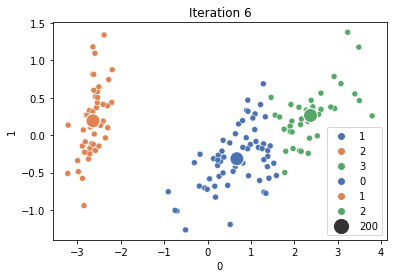

After repeat Kmeans 30 times, the minimum SSE is 4017.5983433418833


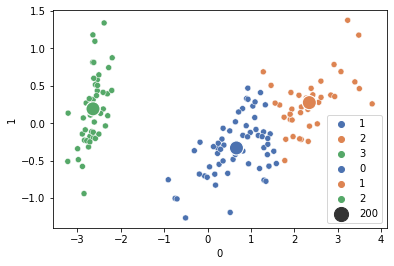

In [289]:
KMeans(df_iris, n_clusters = 3, n_init = 30)

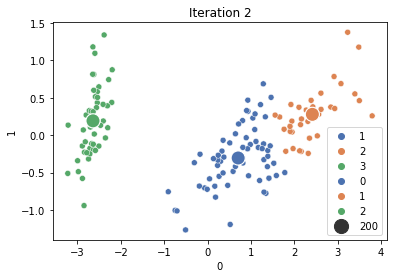

After repeat Kmeans 15 times, the minimum SSE is 3691.3002707031246


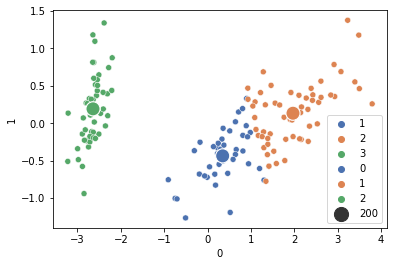

In [265]:
KMeans(df_iris, n_clusters = 3, n_init = 15, Method = "addPoint")

In [291]:
data_min[data_min.closest_centroid == 1].count()

sepal length (cm)    91
sepal width (cm)     91
petal length (cm)    91
petal width (cm)     91
closest_centroid     91
dtype: int64

In [292]:
data_min[data_min.closest_centroid == 2].count()

sepal length (cm)    50
sepal width (cm)     50
petal length (cm)    50
petal width (cm)     50
closest_centroid     50
dtype: int64

In [293]:
data_min[data_min.closest_centroid == 3].count()

sepal length (cm)    9
sepal width (cm)     9
petal length (cm)    9
petal width (cm)     9
closest_centroid     9
dtype: int64